In [1]:
import tensorflow as tf
import numpy as np
import pickle
import itertools

from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def get_model(shape):
    model = Sequential()
    model.add(LSTM(200, return_sequences=True, input_shape=shape))
    model.add(Dropout(0.7))
    model.add(LSTM(200, return_sequences=False))
    model.add(Dropout(0.7))
    model.add(Dense(shape[1]))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    
    return model

def train_model(model, X, y, val_data, epochs=10, batch_size=50):
    history = model.fit(X, y, validation_data=val_data, epochs=epochs, batch_size=batch_size)
    return history
    
def save(model, name):
    model_json = model.to_json()
    with open(name + '.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(name + '.h5')

def load(name):
    # load json and create model
    json_file = open(name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(name + ".h5")
    return model

In [3]:
def get_sonnets(filename):
    """ Returns entire txt file as string. """
    str = ""
    with open(filename) as file:
        for line in file:
            line = line.strip()
            if line.isdigit() == False and len(line) > 0:
                str += line.lower() + "\n"
    return str

In [4]:
file = 'data/shakespeare.txt'
sons = get_sonnets(file)

print ("# chars in txt: " + str(len(sons)))

# chars in txt: 93674


In [5]:
chars = set(sons) # get set of all characters
print(chars)
print ("# unique chars: " + str(len(chars)))

# create mapping of characters to unique ids
dic_char_to_id = dict((c, i) for i, c in enumerate(chars))
dic_id_to_char = dict((i, c) for i, c in enumerate(chars))

{'p', ':', ';', 'e', 'f', 'a', 'z', ' ', '?', 'k', 'h', 'c', 'x', "'", 'i', ',', 'm', 'q', 'n', 'r', 't', '(', 'l', 'u', 'j', ')', 'v', 'g', '\n', '!', 'y', '.', 'w', 'o', '-', 'b', 's', 'd'}
# unique chars: 38


In [6]:
# create input, output sequences

leng = 40
step_size = 2
seqs, nxt_char = [], []
# take all possible subsequences of 40 consecutive characters
for i in range(0, len(sons) - leng, step_size):
    seqs.append(sons[i: i + leng])
    nxt_char.append(sons[i + leng])
print("# seqs: ", len(seqs))

# seqs:  46817


In [7]:
# convert seqs to one-hot encoding
X = np.zeros((len(seqs), leng, len(chars)), dtype=np.bool)
y = np.zeros((len(seqs), len(chars)), dtype=np.bool)

for i, seq in enumerate(seqs):
    for j, char in enumerate(seq):
        X[i, j, dic_char_to_id[char]] = 1
    y[i, dic_char_to_id[nxt_char[i]]] = 1

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
model = get_model((leng, len(chars)))

In [10]:
history = train_model(model, x_train, y_train, (x_test, y_test))

Train on 31367 samples, validate on 15450 samples
Epoch 1/10
31367/31367 [==============================] - 141s 4ms/step - loss: 2.9579 - val_loss: 2.7252
Epoch 2/10
31367/31367 [==============================] - 234s 7ms/step - loss: 2.5634 - val_loss: 2.3824
Epoch 3/10
31367/31367 [==============================] - 253s 8ms/step - loss: 2.3832 - val_loss: 2.2610
Epoch 4/10
31367/31367 [==============================] - 285s 9ms/step - loss: 2.3095 - val_loss: 2.1901
Epoch 5/10
31367/31367 [==============================] - 1061s 34ms/step - loss: 2.2528 - val_loss: 2.1226
Epoch 6/10
31367/31367 [==============================] - 171s 5ms/step - loss: 2.2151 - val_loss: 2.0941
Epoch 7/10
31367/31367 [==============================] - 235s 7ms/step - loss: 2.1810 - val_loss: 2.0505
Epoch 8/10
31367/31367 [==============================] - 261s 8ms/step - loss: 2.1440 - val_loss: 2.0191
Epoch 9/10
31367/31367 [==============================] - 249s 8ms/step - loss: 2.1190 - val_loss: 1

In [11]:
save(model, 'models/Shakespeare_200units_10_50_0.7DROPOUT')

#150 units, 200 units, epochs, batch_size, dropout

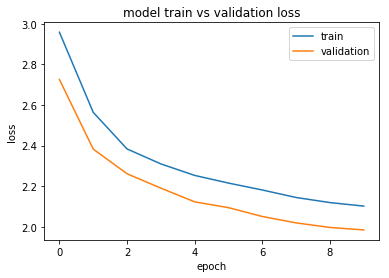

In [18]:
from matplotlib import pyplot

# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.savefig('visuals/Shakespeare_200units_10_50_0.7DROPOUT_loss.png')
pyplot.show()

In [13]:
min(history.history['val_loss']) # 1.7592611852973024

1.9844436664797342

In [14]:
history.history['val_loss'].index(min(history.history['val_loss'])) # 10

9

In [15]:
with open('Shakespeare_200units_10_50_0.7DROPOUT.pkl', 'wb') as f:
    pickle.dump(history, f)

In [16]:
def sample(preds, temperature = 1.0):
    ''' Helper function to sample an index from
    a probability array. Taken from StackOverflow/
    open source code on GitHub. '''

    preds = np.asarray(preds).astype('float')
    preds = np.log(preds) / temperature
    preds[preds == np.inf] = 0

    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return np.argmax(np.random.multinomial(1, preds, 1))

In [17]:
nchar = 800 # length of each line produced from preds
for temp in [1.5, 0.75, 0.25]:
    print( '\n' + '\n' + 'temperature = ' + str(temp) + '\n')
    
    line = 'shall i compare thee to a summer\'s day?\n'
    sentence = line
    
    for i in range(nchar):
        x = np.zeros((1, leng, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, dic_char_to_id[char]] = 1

        preds = model.predict(x, verbose=False)[0]
        nxt_char = dic_id_to_char[sample(preds, temp)]

        line += nxt_char
        sentence = sentence[1:] + nxt_char
        
    print(line)



temperature = 1.5

shall i compare thee to a summer's day?
hes mmeotiny nwanld pna?thy yormre crole
his  skeeeon deantst, foor wrettrtoegit
ny ald qobdool ae thay niwt ric omy,
itive mo, lovis thy a:icr onmed owactt
ailwatib thenwsasep svsy whltflocvtmrktgtwy
me
kuiid mtout' onleyerefeat elolao!res
whrinhd botgod thin ir tham is poadlt anteci, pripsed
this thneade fl'fc. .bunu novtst m, do minenseyasoreitemw?dnfgeis. musceaws yiou worle ofeir vee.
and tomev norewevac prebendeuc, wsy herpelk ie noy hemorrs)
aftelhicrith swolllf eithr fleds.
thoe m.
anl gravecirs by iyrlige eokius,
savlemacu ma,t doib isas my iind,
muse in beios cilco, tman whet my basigtiyn de,
of sonhsaar, betthens sece wilb .whiesur vats aeo(whtulw  rean o velt,a'golnv,
e mopath,rcivet wern
ro's :t thes doicinirgdh the er.ian ,hem,
,ad bpolnsrfs yab p,edlm thoulb crs teeda
knaft 


temperature = 0.75

shall i compare thee to a summer's day?
no the send and that wimh hou the will, are be uatand ele,
and as the chad m